# Week 5: Lexical Semantics

This week we turn our attention to lexical semantics, i.e., the meaning of words.  In this lab, you will be
* exploring the WordNet resource
* learning about lexical relations such as synonymy and hyponymy
* quantifying semantic similarity via distance in the WordNet hierarchy
* comparing WordNet similarity scores with human synonymy judgements




In [ ]:
from google.colab import drive
drive.mount('/content/drive')


First, lets import WordNet from the nltk library

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('wordnet_ic')

from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet_ic as wn_ic


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package wordnet_ic to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet_ic.zip.


## Navigating WordNet

Central to the organisation of WordNet is the idea of a synset.  Words have senses and senses are grouped with synonymous senses (of other words) in **synsets**

If you want to find out which synsets a word belongs to, you use the `synsets` function.  

In [ ]:
wn.synsets("book")

[Synset('book.n.01'),
 Synset('book.n.02'),
 Synset('record.n.05'),
 Synset('script.n.01'),
 Synset('ledger.n.01'),
 Synset('book.n.06'),
 Synset('book.n.07'),
 Synset('koran.n.01'),
 Synset('bible.n.01'),
 Synset('book.n.10'),
 Synset('book.n.11'),
 Synset('book.v.01'),
 Synset('reserve.v.04'),
 Synset('book.v.03'),
 Synset('book.v.04')]

The output is a list of `Synset` objects each of which has a unique identifier containing one of its words, its part of speech and a number.  `Synset('book.n.01')` is the first noun sense of *book*.  However the word book is also in `Synset('record.n.05')` which is the fifth noun sense of *record*.  Lets inspect this synset further.

In [ ]:
book_synsets=wn.synsets('book')
recordn5=book_synsets[2]
print(recordn5.lemma_names())  #get the words in the synset
print(recordn5.definition())   #get the definition of the synset
print(recordn5.examples())  #get examples of the words used in this sense

['record', 'record_book', 'book']
a compilation of the known facts regarding something or someone
["Al Smith used to say, `Let's look at the record'", 'his name is in all the record books']


If you only want to find synsets associated with a particular part of speech of a word then you can give `synsets` an extra argument

In [ ]:
#all of the WN POS tags
parts_of_speech=[wn.NOUN,wn.VERB,wn.ADJ,wn.ADV]

print(wn.synsets("red",parts_of_speech[0]))


[Synset('red.n.01'), Synset('red.n.02'), Synset('bolshevik.n.01'), Synset('loss.n.06')]


### Exercise 1.1
* Write code to compute the number of synsets of each part of speech (noun, verb, adjective and adverb) for each of the following words:- book, chicken, counter, twig, fast, plant
* Store and display the information using a Pandas dataframe

Hint: you could use a nested list comprehension

In [ ]:
import pandas as pd
words=["book","chicken","counter","twig","fast","plant"]

results=[[len(wn.synsets(word,pos)) for pos in parts_of_speech]for word in words]

df =pd.DataFrame(results,index=words,columns=parts_of_speech)
df

,n,v,a,r
book,11,4,0,0
chicken,4,0,1,0
counter,9,2,1,1
twig,1,2,0,0
fast,1,2,10,2
plant,4,6,0,0


The `Synset` object also has `hyponyms` and `hypernyms` methods which return hyponym and hypernym synsets respectively.

For example:

In [ ]:
recordn5.hyponyms()

[Synset('card.n.08'), Synset('logbook.n.01'), Synset('won-lost_record.n.01')]

In [ ]:
for h in recordn5.hypernyms():
  print(h.lemma_names())

['fact']


Since the hyponymy relation forms a tree, we would expect synsets to generally have multiple hyponyms and a single hypernym.  At the top of the tree (also called the **root**), the hypernym list will be empty.  Most noun concepts in WordNet share a common root hypernym which is *entity*.  At the bottom of the tree (also referred to as the **leaves** of the tree), the hyponym list will be empty

### Exercise 1.2
Write a function, `distance_to_root` that will take a Synset and traverse up the tree until it reaches a root of the tree.  When it does so, it should return the number of steps taken.

Hint: This can be done using **recursion**, where a function repeatedly calls itself.  You need to define:
* a base case:  How will the function know when it is at the top of the tree and what should it return?
* a recursive step: In the general case, the function should call itself with a simpler problem (a Synset which is closer to the top of the tree).  When it gets the result of this function call, it needs to modify it in some way and then return its own answer

Make sure you test your function.  You should find that the 5th noun sense of record is 6 steps from the top.

How far are all of the other noun sense of book from a root of the tree?




In [ ]:
def distance_to_root(asynset):
    #print(asynset.lemma_names())
    hypernyms=asynset.hypernyms()
    if len(hypernyms)==0:
        #reached the top and have to stop
        return 0
    else:
        if len(hypernyms)>1:
            print("Warning: multiple hypernyms")
        return (distance_to_root(hypernyms[0])+1)
    
for asynset in wn.synsets('plant',wn.NOUN):
    print(asynset.lemma_names(),distance_to_root(asynset))

['plant', 'works', 'industrial_plant'] 7
['plant', 'flora', 'plant_life'] 6
['plant'] 7
['plant'] 10


## Semantic Similarity in WordNet

The simplest way of defining how similar two concepts are according to WordNet is to use the pathlength measure:

\begin{eqnarray*}
\mbox{sim}(\mbox{synsetA},\mbox{synsetB})=\frac{1}{1+\mbox{lengthOfPath}(\mbox{synsetA},\mbox{synsetB})}
\end{eqnarray*}

We have also introduced other measures in the lectures which incorporate **information content**, i.e., the amount of information we receive when a word from a given synset is used (there is more information in being told that something is a *poodle* than in being told it is an *animal*).

The `nltk.wn` module has built-in functions for computing these similarities between synsets.

In [ ]:
books=wn.synsets("book",wn.NOUN)
print("path_similarity {}".format(wn.path_similarity(books[0],books[1])))

brown_ic=wn_ic.ic("ic-brown.dat")  #this gets information content data from the Brown corpus
print("resnik_similarity {}".format(wn.res_similarity(books[0],books[1],brown_ic)))
print("lin_similarity {}".format(wn.lin_similarity(books[0],books[1],brown_ic)))

path_similarity 0.2
resnik_similarity 5.454686565783099
lin_similarity 0.7098990245459575


Note it is impossible to compare synsets of different parts of speech using these methods because they are not connected via hyponymy

In [ ]:
booksN=wn.synsets("book",wn.NOUN)
booksV=wn.synsets("book",wn.VERB)
print("path_similarity {}".format(wn.path_similarity(booksN[0],booksV[1])))
print("resnik_similarity {}".format(wn.res_similarity(booksN[0],booksV[1],brown_ic)))
print("lin_similarity {}".format(wn.lin_similarity(booksN[0],booksV[1],brown_ic)))

path_similarity None


WordNetError: ignored

### Exercise 2.1

The similarity of two **words** with a given part of speech is defined as the **maximum** similarity of all possible sense pairings.  If word A has 5 noun senses and word B has 4 noun senses than there are 20 possible sense pairings to check.

* Write a function which will compute the path_similarity of two nouns.
* Make sure you test it.  The correct answer for *chicken* and *car* is 0.0909 to 3SF

In [ ]:
def path_similarity(wordA,wordB,pos=wn.NOUN):
    synsetsA=wn.synsets(wordA,pos)
    synsetsB=wn.synsets(wordB,pos)
    maxsofar=0
    for synsetA in synsetsA:
        for synsetB in synsetsB:
            sim=wn.path_similarity(synsetA,synsetB)
            if sim>maxsofar:
                maxsofar=sim
    return maxsofar

path_similarity("chicken","car")

0.09090909090909091

### Exercise 2.2
Generalise your path_similarity function so that it takes an extra optional argument:
* the similarity measure to use


In [ ]:
def word_similarity(wordA,wordB,pos=wn.NOUN,measure="path"):
    synsetsA=wn.synsets(wordA,pos)
    synsetsB=wn.synsets(wordB,pos)
    maxsofar=0
    brown_ic=wn_ic.ic("ic-brown.dat")
    for synsetA in synsetsA:
        for synsetB in synsetsB:
            if measure=="path":
                sim=wn.path_similarity(synsetA,synsetB)
            elif measure=="res":
                sim=wn.res_similarity(synsetA,synsetB,brown_ic)
            elif measure=="lin":
                sim=wn.lin_similarity(synsetA,synsetB,brown_ic)
            
            if sim>maxsofar:
                maxsofar=sim
    return maxsofar

In [ ]:
word_similarity("chicken","car",measure="lin")

0.17900106582025765

## Comparing WordNet Similarities with Human Synonymy Judgements

The file `mcdata.csv` contains human synonymy judgements for a list of 30 noun pairs.   We can read in a `.csv` file using the `csv` library 

In [ ]:
import csv
import os
directory='/content/drive/My Drive/NLE Notebooks/Week5LabsSolutions/'
filename='mcdata.csv'
filepath=os.path.join(directory,filename)


with open(filepath,'r') as filestream:
    mcdata=list(csv.reader(filestream,delimiter=','))

df=pd.DataFrame(mcdata,columns=["word1","word2","human similarity"])
df

,word1,word2,human similarity
0,asylum,madhouse,3.61
1,bird,cock,3.05
2,bird,crane,2.97
3,boy,lad,3.76
4,brother,monk,2.82
5,car,automobile,3.92
6,cemetery,woodland,0.95
7,chord,smile,0.13
8,coast,forest,0.42
9,coast,hill,0.87


Note that the human similarity judgements range between 0 and 4.

### Exercise 3.1
Write code that will 
* compute the WordNet path_similarity for every pair of words in this data; and
* add it as a column in the dataframe.  If you have the path similarity scores in a list called `scores`, you can do this using `df['path']=scores`

Repeat for the Resnik and Lin similarity scores.


In [ ]:
measures=["path","res","lin"]
for measure in measures:
    scores=[]

    for triple in mcdata:
        scores.append(word_similarity(triple[0],triple[1],measure=measure))
    df[measure]=scores
    
df

,word1,word2,human similarity,path,res,lin
0,asylum,madhouse,3.61,0.500000,9.475167,0.855584
1,bird,cock,3.05,0.500000,7.677755,0.773937
2,bird,crane,2.97,0.250000,7.677755,0.747812
3,boy,lad,3.76,0.500000,8.399492,0.830562
4,brother,monk,2.82,0.500000,9.261593,0.986407
5,car,automobile,3.92,1.000000,7.591401,1.000000
6,cemetery,woodland,0.95,0.111111,1.290026,0.123441
7,chord,smile,0.13,0.090909,2.619644,0.246256
8,coast,forest,0.42,0.166667,1.290026,0.130646
9,coast,hill,0.87,0.200000,5.884681,0.599113


We can use pandas functionality to produce scatter plots and examine the correlation between different variables

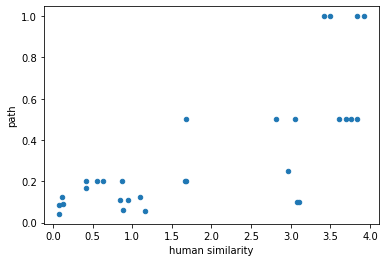

In [ ]:
x="human similarity"
y="path"
def draw_scatter(x,y):

    df[x]=df[x].map(float)
    df[y]=df[y].map(float)
    
    df.plot.scatter(x,y)
draw_scatter(x,y)

### Exercise 3.2
Generate scatter plots showing Resnik similarity against human similarity and Lin similarity against human similarity.

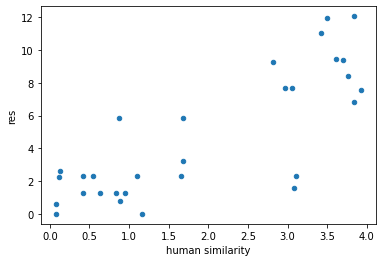

In [ ]:
draw_scatter("human similarity","res")

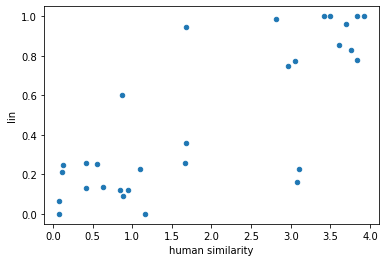

In [ ]:
draw_scatter("human similarity","lin")

The `DataFrame.corr()` method will compute the correlation for all pairs of columns with numeric values.  It is better to use Spearman's rank correlation coefficient than Pearson's product-moment correlation coefficient, since similarity scores are unlikely to be normally distributed.

In [ ]:
df.corr(method='spearman')

,human similarity,path,res,lin
human similarity,1.000000,0.722743,0.735945,0.753510
path,0.722743,1.000000,0.900648,0.945509
res,0.735945,0.900648,1.000000,0.962707
lin,0.753510,0.945509,0.962707,1.000000


### Exercise 3.3
* Looking at the scatter plots and the correlation coefficients, what do you conclude about the different WordNet similarity measures?
* Do you have any reservations about your conclusions?